In [2]:
%load_ext autoreload
from jax import config
# config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/main/learning_particle_gradients/")
from matplotlib.animation import FuncAnimation

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
import optax

import utils
import plot
import distributions
import models
import flows
from tqdm import tqdm
key = random.PRNGKey(0)

import kernels
import metrics
# import seaborn as sns
# sns.set_theme()

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels



In [3]:
# # set up exporting
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
# #     'font.family': 'serif',
# #     'text.usetex': True,
#     'pgf.rcfonts': False,
#     'axes.unicode_minus': False, # avoid unicode error on saving plots with negative numbers (??)
# })

# figure_path = "/home/lauro/documents/msc-thesis/thesis/figures/"
# # save figures by using plt.savefig('path/to/fig')
# # remember that latex textwidth is 5.4in
# # so use figsize=[5.4, 4], for example
# printsize = [5.4, 4]

# 2dim Funnel

In [4]:
n_steps = 1500
particle_lr = 1e-2
learner_lr = 1e-4
n_particles = 200
PATIENCE = 0
# PATIENCE = 15 # try this

In [5]:
target = distributions.Funnel(2)
proposal = distributions.Gaussian(np.array([-3, 0]), np.ones(2))
funnel_setup = distributions.Setup(target, proposal)
target_samples = target.sample(n_particles)

In [6]:
true_samples = target.sample(n_particles)
def plot_true(ax=None):
    if ax is None:
        ax = plt.gca()
    lims=(-15, 15)
    ax.set(xlim=lims, ylim=lims)
    ax.scatter(*np.rollaxis(true_samples, 1), alpha=0.25, label="True", marker=".", color="tab:blue")

In [8]:
# NGF
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, 
                                                                funnel_setup, 
                                                                n_particles=n_particles, 
                                                                n_steps=n_steps, 
                                                                particle_lr=particle_lr, 
                                                                patience=PATIENCE, 
                                                                learner_lr=learner_lr,
                                                                aux=False,
                                                                compute_metrics=metrics.get_funnel_tracer(target_samples))

TypeError: neural_svgd_flow() got an unexpected keyword argument 'bandwidth'

In [9]:
# SVGD
key, subkey = random.split(key)
svgd_grad, svgd_particles, err2 = flows.svgd_flow(subkey, 
                                                    funnel_setup, 
                                                    n_particles=n_particles, 
                                                    n_steps=n_steps, 
                                                    particle_lr=particle_lr,
                                                 bandwidth=None)

  0%|          | 0/1500 [00:00<?, ?it/s]/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/_src/ops/scatter.py:303: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will result in a TypeError. See https://github.com/google/jax/issues/4564 for discussion of why this type of indexing is being deprecated.
  return _scatter_update(
100%|██████████| 1500/1500 [00:08<00:00, 181.01it/s]


In [6]:
# ULA
@jit
def run_chain(key, state):
    kernel = tfp.mcmc.NoUTurnSampler(target.logpdf, 1)
    kernel = tfp.mcmc.UncalibratedLangevin(target.logpdf, 0.1)
    return tfp.mcmc.sample_chain(500,
      current_state=state,
      kernel=kernel,
      trace_fn=None,
      seed=key,
      return_final_kernel_results=True)

key, *keys = random.split(key, 3)
init_state = proposal.sample(1, keys[0])[0]
chain = run_chain(keys[1], init_state)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '


In [7]:
np.exp(chain.final_kernel_results.log_accept_ratio)

AttributeError: 'UncalibratedLangevinKernelResults' object has no attribute 'log_accept_ratio'

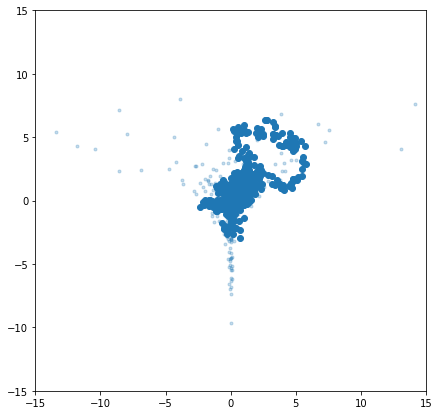

In [9]:
%matplotlib inline
lims=(-15, 15)

fig, ax = plt.subplots(figsize=[7,7])
ax.set(ylim=lims, xlim=lims)
plot_true(ax)
ax.scatter(*np.rollaxis(chain.all_states, 1))

In [16]:
# pULA
n_samples = 100
key, *keys = random.split(key, 3)
init_state = proposal.sample(n_samples, keys[0])
p_chain = vmap(run_chain)(random.split(keys[1], n_samples), init_state)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '


### VI

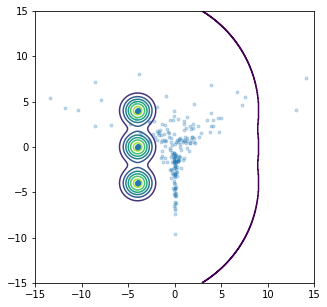

In [55]:
key, subkey = random.split(key)

# parametrize a mixture of three gaussians
means = random.normal(subkey, (3,2))*3 - np.array([[5, 0]]*3) # shape (3,2)
means = np.array([[-4, -4],
                  [-4, 0],
                  [-4, 4]], dtype=np.float32)
covs = np.ones((3, 2))                 # shape (3,2) (diagonals of covariance matrix)
weights = np.ones(3)                    # shape (3,)

# target_dist = tfd.MultivariateNormalDiag(loc=[0,0], scale=[1,3])

def get_dist(means, covs):
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=weights),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=means,
            scale_diag=covs
        )
    )
    return gm

def get_log_density(means, covs):
    dist = get_dist(means, covs)
    return dist.log_prob


def sample(means, covs, n, key):
    dist = get_dist(means, covs)
    return dist.sample(n, key)

def ravel(means, covs):
    return jax.flatten_util.ravel_pytree([means, covs])[0]


params, unravel = jax.flatten_util.ravel_pytree([means, covs])


def log_density(params, x):
    return get_log_density(*unravel(params))(x)

@jit
def loss(params, key):
    """KL(q || p)"""
    samples = sample(*unravel(params), 10**4, key)
    logq = get_log_density(*unravel(params))
    return np.mean(vmap(lambda x: logq(x) - target.logpdf(x))(samples))

@jit
def grad_loss(params, key):
    """grad(KL(q || p))"""
    samples = sample(*unravel(params), 10**4, key)
    def fun(x):
        return grad(log_density)(params, x) * (target.logpdf(x) - log_density(params, x))
    return -np.mean(vmap(fun)(samples), axis=0)

gm = get_dist(means, covs)

# Plot PDF contours.
x = np.linspace(-15., 15., int(1e4), dtype=np.float32)

def meshgrid(x, y=x):
    [gx, gy] = np.meshgrid(x, y, indexing='ij')
    gx, gy = np.float32(gx), np.float32(gy)
    grid = np.concatenate([gx.ravel()[None, :], gy.ravel()[None, :]], axis=0)
    return grid.T.reshape(x.size, y.size, 2)

grid = meshgrid(np.linspace(-10, 10, 500, dtype=np.float32))


%matplotlib inline
fig, ax = plt.subplots(figsize=[5,5])
plot_true(ax)

plt.contour(grid[..., 0], grid[..., 1], gm.prob(grid))
plt.scatter(*np.rollaxis(means, 1))

In [56]:
## reset
# params = param_history[0]
param_history = [params]

In [57]:
schedule = optax.polynomial_schedule(1e-3, 1e-1, .5, 50, transition_begin=10)

# optimize
for count in range(350):
    key, subkey = random.split(key)
#     params = params - eta * grad(loss)(params, subkey)
    params = params - schedule(count) * grad_loss(params, subkey)
    param_history.append(params)

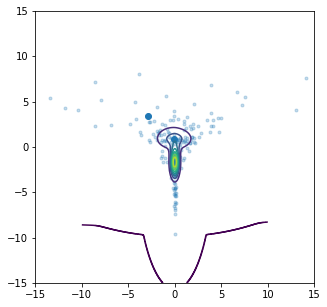

In [58]:
%matplotlib inline
means, covs = unravel(params)
gm = get_dist(means, covs)

fig, ax = plt.subplots(figsize=[5,5])
plot_true(ax)
ax.contour(grid[..., 0], grid[..., 1], gm.prob(grid))
ax.scatter(*np.rollaxis(means, 1))
# ax.scatter(*np.rollaxis(gm.sample(100, subkey), 1))

# Animate density

In [12]:
from celluloid import Camera
writer = matplotlib.animation.writers['ffmpeg'](fps=30)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

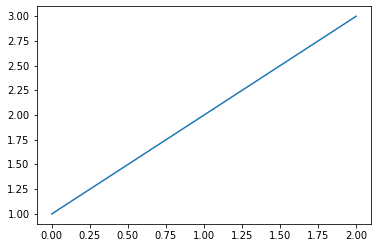

In [60]:
%matplotlib widget
plt.plot([1,2,3])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

100%|██████████| 351/351 [04:24<00:00,  1.33it/s]


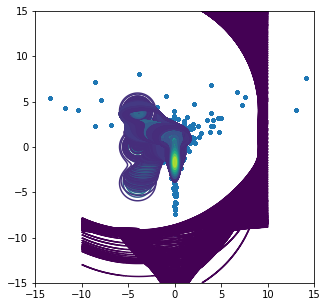

In [61]:
%matplotlib widget


fig, ax = plt.subplots(figsize=[5,5])
camera = Camera(fig)

for params in tqdm(param_history):
    means, covs = unravel(params)
    gm = get_dist(means, covs)

    plot_true(ax)
    ax.contour(grid[..., 0], grid[..., 1], gm.prob(grid), cmap="viridis")
    ax.scatter(*np.rollaxis(means, 1), color="tab:blue")

    camera.snap()

anim = camera.animate()

In [62]:
anim.save("vi.mp4", writer=writer, dpi=200)

# Animate particle flow

In [63]:
%matplotlib widget
lims = (-5, 5)
fig, ax = plt.subplots(figsize=[7,7])
ax.set(xlim=lims, ylim=lims)

plot_true(ax)
anim = plot.animate_array(neural_particles.rundata["particles"].training, fig, ax=ax, interval=10, color="tab:orange")
# anim

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [64]:
anim.save("ngf.mp4", writer=writer, dpi=200)

# Animate chain

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

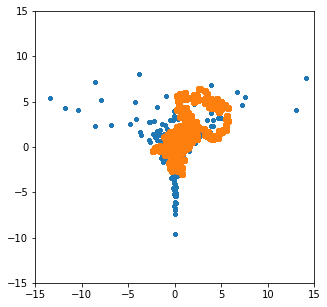

In [12]:
%matplotlib widget

fig, ax = plt.subplots(figsize=[5,5])
ax.set(ylim=lims, xlim=lims)

camera = Camera(fig)
samples = np.rollaxis(chain.all_states, 1)

for i in range(1, 500):
    plot_true(ax)
    ax.scatter(*samples[:, :i], color="tab:orange")
    camera.snap()

animation = camera.animate()

In [13]:
animation.save("mcmc.mp4", writer=writer, dpi=200)

# Animate pULA

In [17]:
p_chain.all_states.shape

(100, 500, 2)

In [19]:
%matplotlib widget

fig, ax = plt.subplots(figsize=[5,5])
ax.set(ylim=lims, xlim=lims)

camera = Camera(fig)

for samples in np.rollaxis(p_chain.all_states, 1):
    plot_true(ax)
    ax.scatter(*np.rollaxis(samples, 1), color="tab:orange")
    camera.snap()

animation = camera.animate()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
animation.save("pula.mp4", writer=writer, dpi=200)

# Animate SVGD

In [10]:
%matplotlib widget
lims = (-5, 5)
fig, ax = plt.subplots(figsize=[7,7])
ax.set(xlim=lims, ylim=lims)

plot_true(ax)
anim = plot.animate_array(svgd_particles.rundata["particles"].training, fig, ax=ax, interval=10, color="tab:orange")
# anim

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
anim.save("svgd.mp4", writer=writer, dpi=200)